# First, import data

In [1]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *

In [2]:
# Get images with segmentation

which_slice = 15
alpha = 0.15

f = lambda tif : (alpha*tif.asarray()[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')
with tifffile.TiffFile(vol0) as tif:
    im1 = f(tif)

vol1 = os.path.join(dat_foldername, 'img101.tif')
with tifffile.TiffFile(vol1) as tif:
    im2 = f(tif)

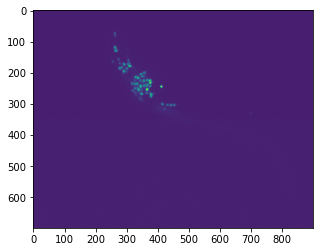

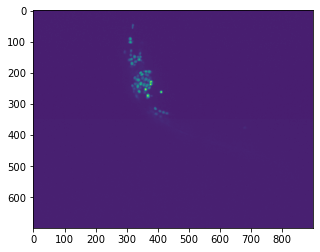

In [3]:
plt.imshow(im1)
plt.figure()
plt.imshow(im2)

In [4]:
im1.shape

(700, 900)

## Get segmentation and matching points

In [5]:
import cv2
import open3d as o3d


In [6]:
im1.shape

(700, 900)

In [7]:
keypoints0, keypoints1, matches = detect_features_and_match(im1, im2)

features0, features1 = extract_location_of_matches(matches, keypoints0, keypoints1)

In [8]:
# Second, assign features to segmented neurons and match neurons

# Load segmentation centroids
seg_fname0 = os.path.join(dat_foldername, 'test_vol0.txt')
seg_vol0 = np.loadtxt(seg_fname0)
# TODO: text files are saved in a reduced location space
neurons0 = np.array([bcpd_to_pixels(row) for row in seg_vol0])

seg_fname1 = os.path.join(dat_foldername, 'test_vol1.txt')
seg_vol1 = np.loadtxt(seg_fname1)
neurons1 = np.array([bcpd_to_pixels(row) for row in seg_vol1])

In [9]:
dat,_=match_centroids_using_tree(neurons0, 
                               neurons1, 
                               features0, 
                               features1,
                               radius=5,
                               max_nn=20,
                               which_slice=which_slice)

In [10]:
n0, pc_n0, tree_neurons0 = build_neuron_tree(neurons0)
n1, pc_n1, tree_neurons1 = build_neuron_tree(neurons1)
pc_n0.paint_uniform_color([0.5,0.5,0.5])
pc_n1.paint_uniform_color([0,0,0])

# Plot lines from initial neuron to target
points = np.vstack((pc_n0.points,pc_n1.points))

tmp = dat.copy()
for i,match in enumerate(dat):
    tmp[i][1] = (n0 + match[1])#.astype('uint32')

successful_lines = []
failed_lines = []
for row in tmp:
    if row[1] != n0:
        successful_lines.append(row)
    else:
        failed_lines.append(row)

In [11]:
successful_colors = [[0, 1, 0] for i in range(len(successful_lines))]
successful_line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(successful_lines),
)
failed_colors = [[1, 0, 0] for i in range(len(failed_lines))]
failed_line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(failed_lines),
)
failed_line_set.colors = o3d.utility.Vector3dVector(failed_colors)
successful_line_set.colors = o3d.utility.Vector3dVector(successful_colors)
o3d.visualization.draw_geometries([failed_line_set, successful_line_set, pc_n0, pc_n1])

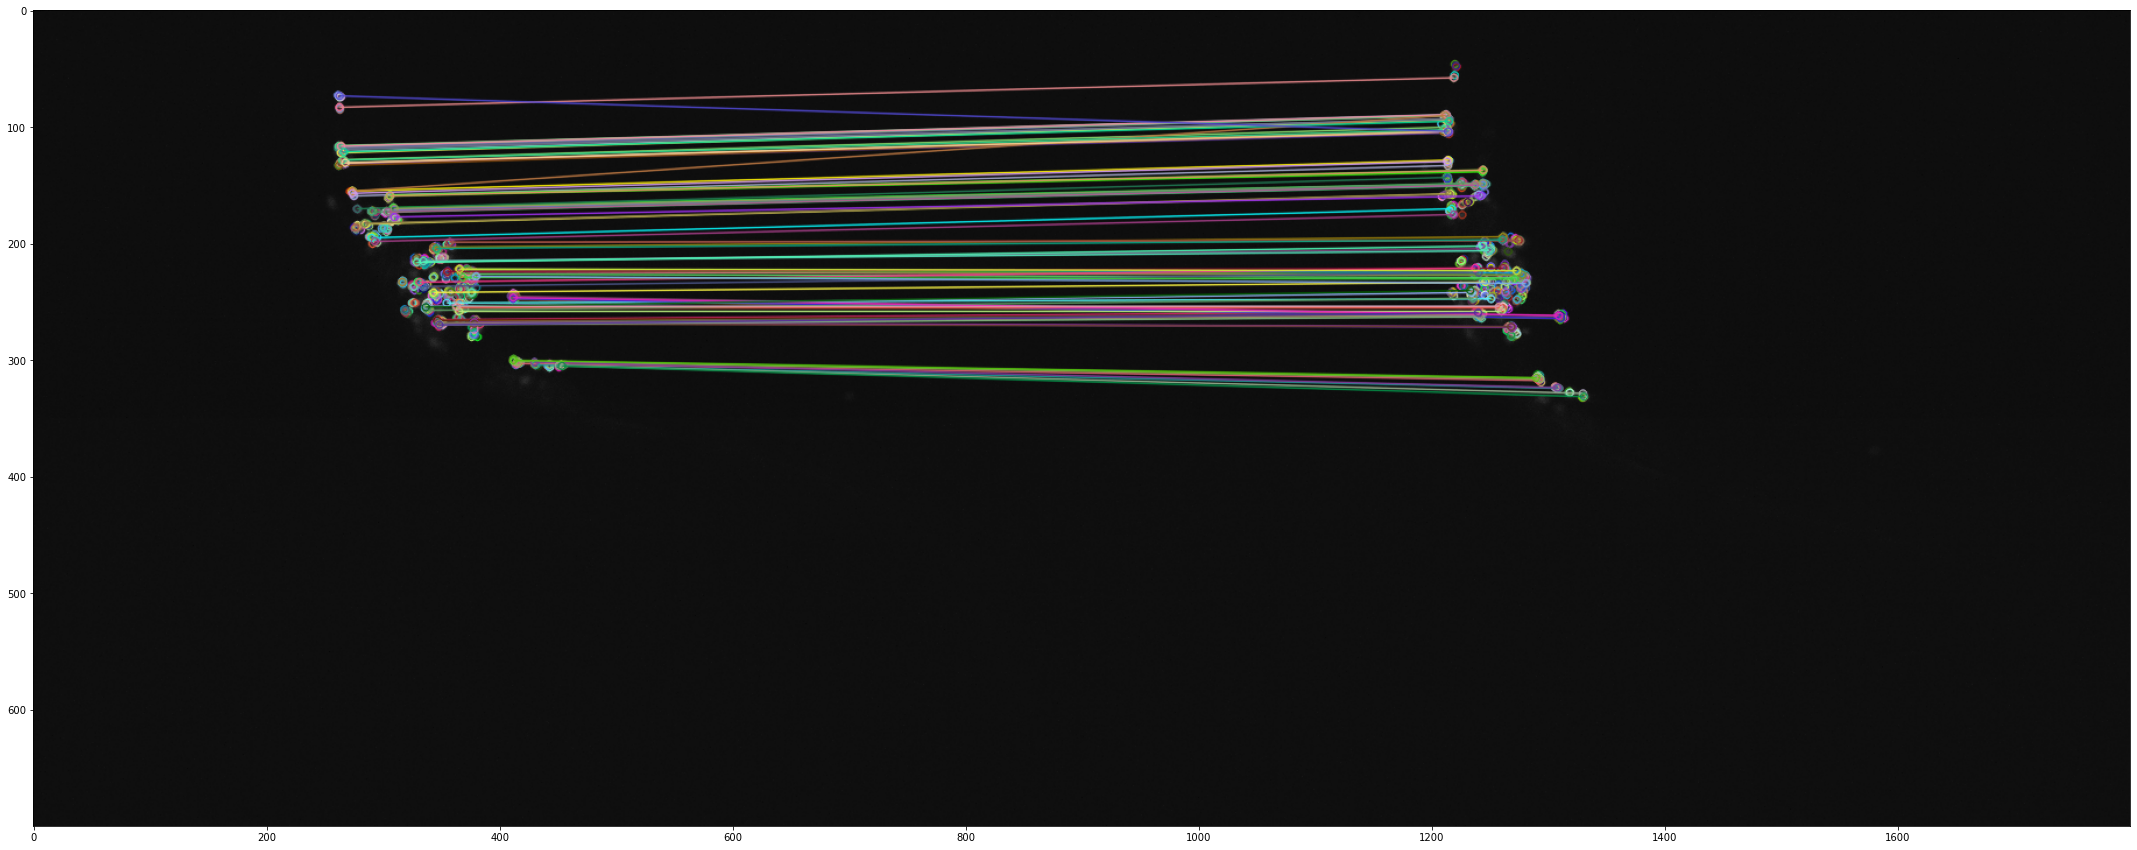

In [12]:

imMatches = cv2.drawMatches(im1, keypoints0, im2, keypoints1, matches, None)
fig, axis = plt.subplots(figsize=(45, 15))

plt.imshow(imMatches)

## Full: build features on all planes

In [13]:
# Second, assign features to segmented neurons and match neurons

# Load segmentation centroids
seg_fname0 = os.path.join(dat_foldername, 'test_vol0.txt')
seg_vol0 = np.loadtxt(seg_fname0)
# TODO: text files are saved in a reduced location space
neurons0 = np.array([bcpd_to_pixels(row) for row in seg_vol0])

seg_fname1 = os.path.join(dat_foldername, 'test_vol1.txt')
seg_vol1 = np.loadtxt(seg_fname1)
neurons1 = np.array([bcpd_to_pixels(row) for row in seg_vol1])

all_features0, all_features1, kp0, kp1 = build_features_on_all_planes('img100.tif','img101.tif',verbose=1, 
                                                            detect_keypoints=True,
                                                            kp0=neurons0,
                                                            kp1=neurons1)

In [14]:
dat, f2n=match_centroids_using_tree(neurons0, 
                               neurons1, 
                               all_features0, 
                               all_features1,
                               radius=5,
                               max_nn=50,
                               min_features_needed=1,
                                   verbose=1)

Could not match neuron 0
Matched neuron 1 based on 1 features
Matched neuron 2 based on 33 features
Matched neuron 3 based on 17 features
Matched neuron 4 based on 32 features
Matched neuron 5 based on 19 features
Matched neuron 6 based on 37 features
Matched neuron 7 based on 12 features
Matched neuron 8 based on 15 features
Matched neuron 9 based on 3 features
Matched neuron 10 based on 39 features
Matched neuron 11 based on 31 features
Matched neuron 12 based on 5 features
Matched neuron 13 based on 24 features
Matched neuron 14 based on 9 features
Matched neuron 15 based on 27 features
Matched neuron 16 based on 11 features
Matched neuron 17 based on 16 features
Matched neuron 18 based on 7 features
Could not match neuron 19
Matched neuron 20 based on 9 features
Matched neuron 21 based on 8 features
Matched neuron 22 based on 3 features
Matched neuron 23 based on 1 features
Matched neuron 24 based on 2 features
Matched neuron 25 based on 30 features
Matched neuron 26 based on 47 fe

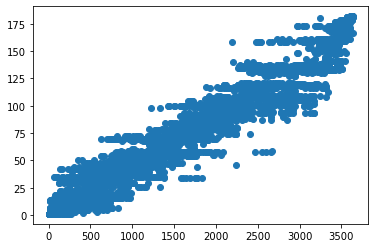

In [15]:
plt.plot(f2n, 'o')

In [16]:
visualize_tracks(neurons0, neurons1, dat, to_plot_failed_lines=False)